<a href="https://colab.research.google.com/github/liu-bioinfo-lab/general_AI_model/blob/main/epcotv2_basic_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please open Google Colab notebook under TPU/GPU setting : **Runtime -> Change runtime type**

In [1]:
!git clone https://github.com/liu-bioinfo-lab/general_AI_model.git
%cd general_AI_model

Cloning into 'general_AI_model'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 197 (delta 45), reused 18 (delta 8), pack-reused 111 (from 2)
Receiving objects: 100% (197/197), 68.72 MiB | 50.12 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (97/97), done.
/scratch/drjieliu_root/drjieliu/lhjiang/eRNA/evaluation/test/general_AI_model


In [2]:
import os
import gdown
from src.model import build_model
import argparse
import torch
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  import torch_xla.distributed.xla_multiprocessing as xmp
except Exception as e:
  print(f" Error: {e}")
!pip install kipoiseq==0.5.2 --quiet > /dev/null
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.tutorial_utils import FastaStringExtractor, prepare_input, extract_outputs, get_args

 Error: No module named 'torch_xla'


**Download Model**

In [3]:
os.makedirs('models', exist_ok=True)
model_path = 'models/ckpt.pt'
gdown.download('https://drive.google.com/uc?id=1aTpGvAUkvaxsDP_isA2n2Udbfqa9walW', model_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1aTpGvAUkvaxsDP_isA2n2Udbfqa9walW
To: /scratch/drjieliu_root/drjieliu/lhjiang/eRNA/evaluation/test/general_AI_model/models/ckpt.pt
100%|██████████| 468M/468M [00:11<00:00, 41.1MB/s] 


'models/ckpt.pt'

In [4]:

### The following codes are copied from https://github.com/deepmind/deepmind-research/blob/master/enformer/enformer-usage.ipynb
fasta_file = 'data/genome.fa'
!mkdir -p data
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls data

fasta_extractor = FastaStringExtractor(fasta_file)

--2025-10-01 20:50:19--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving proxy1.arc-ts.umich.edu (proxy1.arc-ts.umich.edu)... 141.211.192.53
Connecting to proxy1.arc-ts.umich.edu (proxy1.arc-ts.umich.edu)|141.211.192.53|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  20.3MB/s    in 44s     

2025-10-01 20:51:05 (21.1 MB/s) - written to stdout [983659424/983659424]

accession_number.xlsx  epi_list		  genome.fa.fai		  README.md
black_list.bed	       extra_tf_list.txt  hic_process.py
data_read.py	       genome.fa	  input_region_600kb.bed


In [5]:
# Download a downsampled GM12878 ATAC-seq for example
os.makedirs('tmp_save', exist_ok=True)
atac_path = 'tmp_save/GM12878_ATAC.pickle'
gdown.download('https://drive.google.com/uc?id=1ua-fQHYjPH658oEKEpIaDBHNFbzsO1m0', atac_path, quiet=False)
with open(atac_path, 'rb') as f:
    atac_data = pickle.load(f)

Downloading...
From: https://drive.google.com/uc?id=1ua-fQHYjPH658oEKEpIaDBHNFbzsO1m0
To: /scratch/drjieliu_root/drjieliu/lhjiang/eRNA/evaluation/test/general_AI_model/tmp_save/GM12878_ATAC.pickle
100%|██████████| 192M/192M [00:08<00:00, 23.5MB/s] 
/tmp/ipykernel_2762913/3254570976.py:6: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  atac_data = pickle.load(f)


### Load model

In [6]:
args = get_args()
try:
    device = xm.xla_device()
    print(f"XLA device detected: {device}")
except Exception as e:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"No XLA device detected. Error: {e}")

model = build_model(args)
model.load_state_dict(torch.load(model_path, map_location='cpu'),strict=True)
model.eval()
model.to(device)
device

No XLA device detected. Error: name 'xm' is not defined


/tmp/ipykernel_2762913/2176896603.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='cpu'),strict=True)


device(type='cuda', index=0)

### Run model to get 1D and 2D representations over a 500kb region

In [7]:
# specify a 500kb region

chrom, start, end = ['chr1', 1500000, 2000000]

input_x = prepare_input(
    fasta_extractor,
    chrom, start, end,
    atac_data
).to(device)

outputs = model(input_x,return_rep=True)

rep1d, rep2d = extract_outputs(outputs)

#### embedding size

In [8]:
## representation of each 1kb bin and interactions among 1kb bins in 500kb region
rep1d.shape, rep2d.shape

((500, 960), (500, 500, 96))

### Prediction

In [9]:
modalities=['epi', 'rna', 'bru', 'microc', 'hic','intacthic','rna_strand','external_tf', 'tt', 'groseq', 'grocap', 'proseq','netcage','starr']
_, _, output,external_output = outputs
mix_output=[out.cpu().data.detach().numpy() for out in (output+external_output)]
out_dic=dict(zip(modalities,mix_output))

In [10]:
# the last dimension corresponds to modalities being predicted
for m in modalities:
    print(m,out_dic[m].shape)

epi (1, 500, 247)
rna (1, 500, 3)
bru (1, 500, 3)
microc (1, 500, 500, 2)
hic (1, 100, 100, 3)
intacthic (1, 500, 500, 2)
rna_strand (1, 500, 2)
external_tf (1, 500, 708)
tt (1, 500, 2)
groseq (1, 500, 2)
grocap (1, 500, 4)
proseq (1, 500, 3)
netcage (1, 500, 2)
starr (1, 500, 1)


### Explanation of each modality that can be predicted

* __Epigenomic features (epi).__ The list of epigenomic features can be found in "data/epi_list".

* __RNA-seq (rna).__
  - CAGE-seq
  - Total RNA-seq
  - PolyA+ RNA-seq

* __Bru-seq (bru).__
  - Bru-seq
  - BruUV-seq
  - BruChase-seq

* __Micro-c (microc).__
  - O/E normalized Micro-C
  - KR normalized Micro-C

* __Hi-C (hic).__
  - CTCF ChIA-PET
  - RNApol2 ChIA-PET
  - Hi-C

* __Intact Hi-C (intacthic).__
  - O/E normalized intact Hi-C
  - KR normalized intact Hi-C

* __RNA Strand (rna_strand).__
  - Total RNA-seq (forward)
  - Total RNA-seq (reverse)

* __Additional TFs (external_tf).__ The list of additional TFs can be found on Github in a file named unseen_tf.txt.

* __TT-seq (tt).__
  - TT-seq (forward)
  - TT-seq (reverse)

* __GRO-seq (groseq).__
  - GRO-seq (forward)
  - GRO-seq (reverse)

* __GRO-cap (grocap).__
  - GRO-cap (forward)
  - GRO-cap (reverse)
  - GRO-cap_wTAP (forward)
  - GRO-cap_wTAP(reverse)

* __PRO-seq (proseq).__
  - PRO-seq (forward)
  - PRO-seq (reverse)
  - PRO-cap

* __NET-CAGE (netcage).__
  - NET-CAGE (forward)
  - NET-CAGE (reverse)

* __STARR-seq (starr).__ STARR-seq

### Visualization

#### 2D map

In [ ]:
hic=out_dic["hic"] # also for microc, intacthic
hic_map=hic[0,:,:,0]

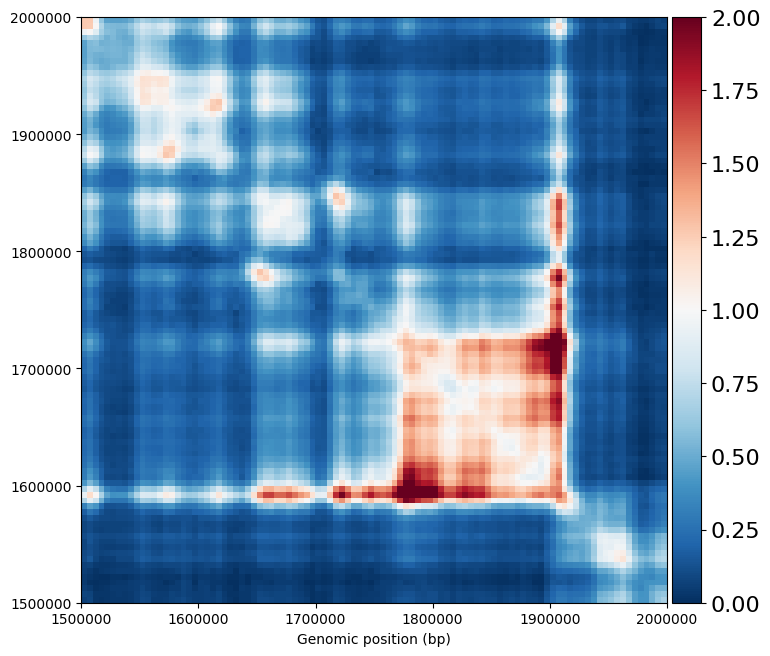

In [ ]:
hic_map = np.squeeze(hic_map)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(hic_map.squeeze(),cmap='RdBu_r',vmin=0,vmax=2,extent=[start, end, start, end],)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
# ax.set_yticks([])
# ax.set_xticks([])
plt.show()

#### 1D sequence

In [ ]:
epi_data=out_dic["epi"] # Also for other one dimential sequence
epi_map=epi_data[0,:,1] # You can check the epi list at data/epi_list

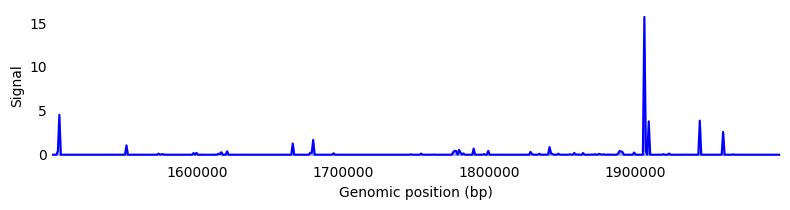

In [ ]:
n_bins = epi_map.shape[0]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, ax = plt.subplots(figsize=(8, 2.2))
sig = np.clip(epi_map, 0, None)
ax.plot(genomic_coords, sig, color='blue', lw=1.5)
ax.fill_between(genomic_coords, 0, sig, alpha=0.3, color='blue')

xlim = (genomic_coords.min(), genomic_coords.max())
ax.set_xlim(xlim)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.ticklabel_format(axis='x', style='plain', useOffset=False)
ax.set_xlabel("Genomic position (bp)", fontsize=10)
ax.set_ylabel("Signal", fontsize=10)
plt.tight_layout()

plt.show()


#### Nascent RNA profiles

In [11]:
tt_data = out_dic['tt']
bru_data = out_dic['bru']
groseq_data = out_dic['groseq']

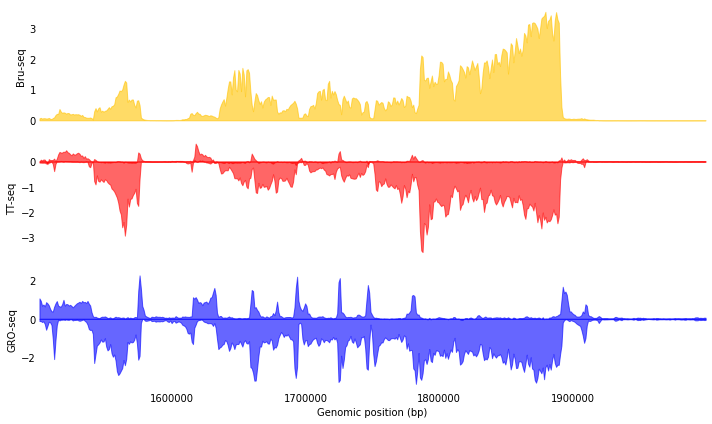

In [12]:
n_bins = tt_data.shape[1]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Bru-seq Track
axes[0].fill_between(genomic_coords, 0, bru_data[0,:,0], color='#FFC300', alpha=0.6)
axes[0].set_ylabel("Bru-seq", fontsize=10)

# TT-seq Track (strand-specific)
axes[1].fill_between(genomic_coords, 0, tt_data[0,:,0], color='r', alpha=0.6)
axes[1].fill_between(genomic_coords, 0, -tt_data[0,:,1], color='r', alpha=0.6)
axes[1].set_ylabel("TT-seq", fontsize=10)

# GRO-seq Track (strand-specific)
axes[2].fill_between(genomic_coords, 0, groseq_data[0,:,0], color='b', alpha=0.6)
axes[2].fill_between(genomic_coords, 0, -groseq_data[0,:,1], color='b', alpha=0.6)
axes[2].set_ylabel("GRO-seq", fontsize=10)
axes[2].set_xlabel("Genomic position (bp)", fontsize=10)

xlim = (genomic_coords.min(), genomic_coords.max())
for ax in axes:
    ax.set_xlim(xlim)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.ticklabel_format(axis='x', style='plain', useOffset=False)

plt.tight_layout()
plt.show()

#### Gene expression

In [13]:
rna_data = out_dic['rna']
rna_strand_data = out_dic['rna_strand']

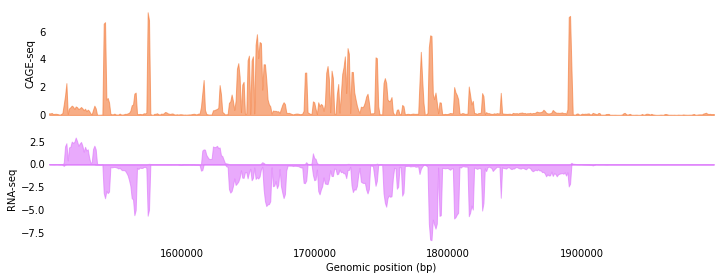

In [14]:
n_bins = rna_data.shape[1]
pixel_width   = (end - start) / n_bins
genomic_coords = start + pixel_width/2 + np.arange(n_bins) * pixel_width
fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

# CAGE-seq Track
axes[0].fill_between(genomic_coords, 0, rna_data[0,:,0], color='#f37735', alpha=0.6)
axes[0].set_ylabel("CAGE-seq", fontsize=10)

# RNA-seq Track (strand-specific)
axes[1].fill_between(genomic_coords, 0, rna_strand_data[0,:,0], color='#DB72FB', alpha=0.6)
axes[1].fill_between(genomic_coords, 0, -rna_strand_data[0,:,1], color='#DB72FB', alpha=0.6)
axes[1].set_ylabel("RNA-seq", fontsize=10)
axes[1].set_xlabel("Genomic position (bp)", fontsize=10)

xlim = (genomic_coords.min(), genomic_coords.max())
for ax in axes:
    ax.set_xlim(xlim)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.ticklabel_format(axis='x', style='plain', useOffset=False)

plt.tight_layout()
plt.show()